Data analysis and figure production for

# Predicting growth in a mixed culture from growth curves

by Yoav Ram, Eynat Deluss-Gur, Uri Obolski, Maayan Bibi, Judith Berman, and Lilach Hadany.

*A manuscript in preparation.*

#### Preprint: 

Ram et al. (2015) Predicting competition results from growth curves. bioRxiv doi: [10.1101/022640](http://biorxiv.org/content/early/2015/07/23/022640).

#### Notebook
This [Jupyter notebook](http://jupyter.org/) is an electronic supplementry material of the article.

The notebook **will be available** at <https://github.com/yoavram/curveball_ms/blob/master/supp.ipynb>.

The [Curveball](http://curveball.yoavram.com) package, used to analyze growth curves, predict growth in a mixed culture, and infer relative fitness, can be found at <http://curveball.yoavram.com> or on [Github](https://github.com/yoavram/curveball).

In [1]:
import pkg_resources
import os
import collections

import matplotlib.pyplot as plt
plt.warnings.simplefilter('ignore', FutureWarning)
plt.warnings.simplefilter('ignore', DeprecationWarning)
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.integrate import odeint
import seaborn as sns

%matplotlib inline
sns.set(style='white', context='paper', font_scale=2, palette='Set1')
red, blue, green = sns.color_palette('Set1', 3)
width, height = plt.rcParams['figure.figsize']
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['lines.markersize'] = 7.5
panel_label_size = plt.rcParams[ 'axes.titlesize']*1.3
fit_ls = '-' # model fit linestyle
pred_ls = '--' # model prediction linestyle
fixed_pred_ls = '-.' # prediction without competition coefficients linestyle

In [2]:
import curveball
import curveball.scripts.cli
print('Curveball, ', curveball.__version__)
folder = os.path.join('D:\\', 'Dropbox', 'ex silico') # change to match your data folder
print('Working folder:', folder)

Curveball,  0.2.3+19.g523b302.dirty
Working folder: D:\Dropbox\ex silico


In [3]:
def fig_xlabel(fig, label):
    fig.text(0.5, 0, label, horizontalalignment='center', verticalalignment='bottom')

In [4]:
datasets = collections.OrderedDict()
datasets['2015-11-18'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_181115.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_181115.xlsx'),
    'max_time': 12,
    'bad_wells': ['B2','E1','C4','A2'] + # G outliers
                 ['H9','C11','A10','C12','A11','A9','C9','H11'] + # R outliers
                 ['E5','E8','H6','H8','H7','H5'], # RG outliers
    'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2015-11-18.csv'),
    'lag': True,
    'ylim': (0, 0.8)
}
datasets['2015-12-14'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_141215.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_141215.xlsx'),
    'max_time': 7,
    'bad_wells': ['{}{}'.format(c, i) for c in 'ABCDEFGH' for i in range(4, 8)] + # used for flow samples
                 ['B10','B11','C10','A11','E11','A12'] + # red outliers
                 ['D8','H8'], # RG outliers
    'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2015-12-14.csv'),
    'lag': False,
    'ylim': (0, 0.8)
}
datasets['2016-01-06'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_060116.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_060116.xlsx'),
    'max_time': 10,
    'bad_wells': #['{}{}'.format(c, i) for c in 'BCDEG' for i in range(4, 8)] + # used for flow samples                 
                 ['A4','F4','G3'] + # G outliers
                 ['E12','A10','D10'] + # R outliers
                 ['H5','H6','G8'] , # RG outliers
    'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2016-01-06.csv'),
    'lag': True,
    'ylim': (0, 0.8)
}
# datasets['2016-01-20'] = {
#     'plate_file': os.path.join(folder, 'tecan', 'plate_200116.csv'),
#     'OD_file': os.path.join(folder, 'tecan', 'Yoav_200116.xlsx'),
#     'max_time': 15,
#     'bad_wells': ['{}{}'.format(c, i) for c in 'ABCDEFGH' for i in range(4, 8)] + # used for flow samples                 
#                  ['E1','H3','B2'] + # G outliers
#                  [] + # R outliers
#                  [] , # RG outliers
#     'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2016-01-20.csv'),
#     'lag': True,
#     'ylim': (0, 1.8)
# }
# datasets['2015-12-23'] = {
#     'plate_file': os.path.join(folder, 'tecan', 'plate_231215.csv'),
#     'OD_file': os.path.join(folder, 'tecan', 'Yoav_231215.xlsx'),
#     'max_time': 8,
#     'bad_wells': ['{}{}'.format(c, i) for c in 'ABCDEFGH' for i in range(4, 8)] + # used for flow samples
#                  ['A1'] + # G outliers
#                  ['D11','A11','A12','D10','H10','C10'] + # R outliers
#                  ['A8','A9', 'B8', 'B9', 'C9', 'D8', 'H8'], # RG outliers
#     'flow_mean_file': os.path.join(folder, 'flow', 'mean_df_2015-12-23.csv'),
#     'flow_std_file': os.path.join(folder, 'flow', 'std_df_2015-12-23.csv'),
#     'lag': False
# }

In [5]:
for ds in datasets.values():
    ds['plate'] = pd.read_csv(ds['plate_file'])
    ds['df'] = curveball.ioutils.read_tecan_xlsx(ds['OD_file'], plate=ds['plate'], max_time=ds['max_time'])
    ds['df'] = ds['df'][~ds['df'].Well.isin(ds['bad_wells'])]
    ds['dfG'] = ds['df'][ds['df'].Strain.str.contains('GFP')]
    ds['dfR'] = ds['df'][ds['df'].Strain.str.contains('RFP')]
    ds['dfRG'] = ds['df'][ds['df'].Strain=='mixed']
    ds['RG0_mean'] = ds['dfRG'][(ds['dfRG'].Time==ds['dfRG'].Time.min())].OD.mean()
    ds['RG_time'] = ds['dfRG'].Time.unique()
    ds['RG_mean'] = ds['dfRG'].groupby(by='Time').OD.mean()
    ds['RG_std'] = ds['dfRG'].groupby(by='Time').OD.std(ddof=1)

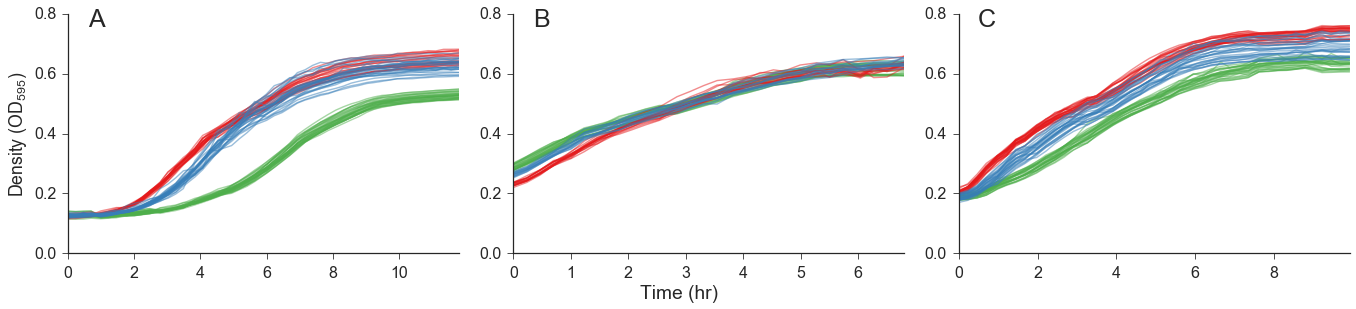

In [6]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=False, figsize=(width * cols, height))
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i,(name, ds) in enumerate(datasets.items()):
    for well in ds['dfG'].Well.unique():
        ds['dfG'][ds['dfG'].Well==well].plot(x='Time', y='OD', color=green, alpha=0.5, ax=ax[i])
    for well in ds['dfR'].Well.unique():
        ds['dfR'][ds['dfR'].Well==well].plot(x='Time', y='OD', color=red, alpha=0.5, ax=ax[i])
    for well in ds['dfRG'].Well.unique():
        ds['dfRG'][ds['dfRG'].Well==well].plot(x='Time', y='OD', color=blue, alpha=0.5, ax=ax[i])
    ax[i].set(title='', xlabel='')
    if 'ylim' in ds:
        ax[i].set_ylim(ds['ylim'])
        dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
        ax[i].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
    if i == 0:
        ax[i].set(
            ylabel=r'Density ($OD_{595}$)'            
        )
    else:
        ax[i].set(ylabel='')
    lg = ax[i].legend()
    if lg:
        lg.set_visible(False)
    
fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCDEFG'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-wells.png')
fig.savefig('Fig-wells.pdf', dpi=300)

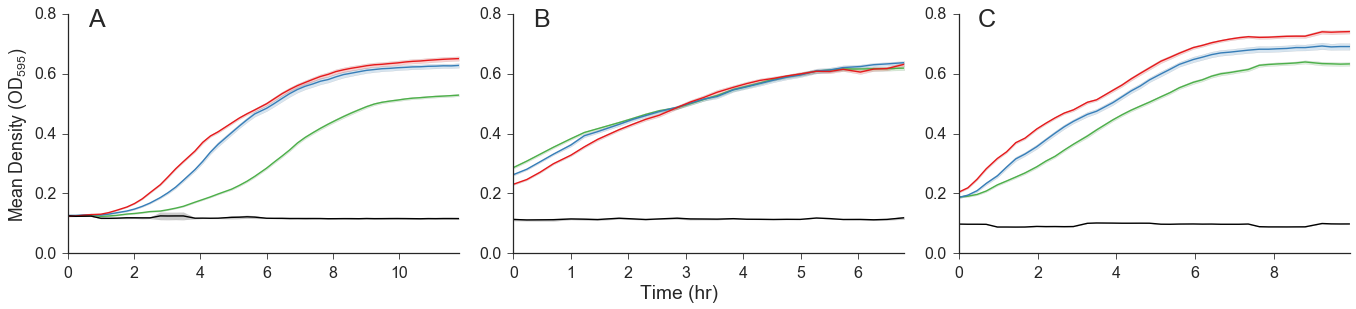

In [7]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=False, figsize=(width * cols, height))
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i,(name, ds) in enumerate(datasets.items()):
    curveball.plots.tsplot(ds['df'], ax=ax[i])
    ax[i].set(title='', xlabel='')
    if 'ylim' in ds:
        ax[i].set_ylim(ds['ylim'])
        dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
        ax[i].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
    if i == 0:
        ax[i].set(ylabel=r'Mean Density ($OD_{595}$)')     
    else:
        ax[i].set(ylabel='')
    ax[i].legend().set_visible(False)
fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCDEFG'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
fig.savefig('Fig-tsplot.png')
fig.savefig('Fig-tsplot.pdf', dpi=300)

In [8]:
for ds in datasets.values():
    param_fix = {'y0', 'K'}
    param_guess = None
    if not ds['lag']:
        param_fix.add('q0')
        param_fix.add('v')
        param_guess = {'q0': np.inf, 'v': np.inf}
    models_G = curveball.models.fit_model(ds['dfG'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_G'] = models_G[0]
    models_R = curveball.models.fit_model(ds['dfR'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_R'] = models_R[0]
    models_RG = curveball.models.fit_model(ds['dfRG'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_RG'] = models_RG[0]

In [9]:
for name, ds in datasets.items():
    print(name, 'G', ds['model_G'].model.name)
    print(name, 'R', ds['model_R'].model.name)
    print(name, 'RG', ds['model_RG'].model.name)

2015-11-18 G Model(BaranyiRoberts)
2015-11-18 R Model(LogisticLag2)
2015-11-18 RG Model(LogisticLag2)
2015-12-14 G Model(BaranyiRoberts)
2015-12-14 R Model(BaranyiRoberts)
2015-12-14 RG Model(Logistic)
2016-01-06 G Model(LogisticLag2)
2016-01-06 R Model(BaranyiRoberts)
2016-01-06 RG Model(BaranyiRoberts)


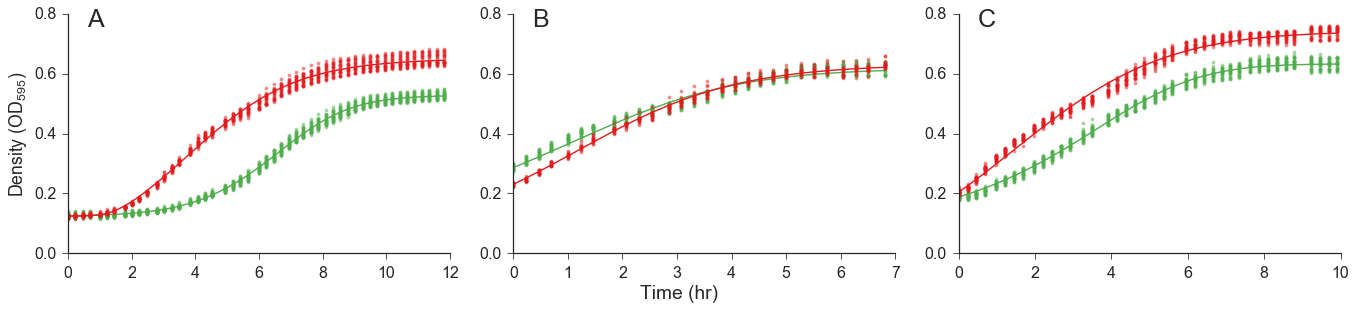

In [10]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=False, figsize=(width * cols, height))
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i,(name, ds) in enumerate(datasets.items()):
    ds['model_G'].plot_fit(ax=ax[i], fit_kws={'color':green, 'ls':fit_ls}, data_kws={'color':green,'alpha':0.5, 'marker':'.'}, init_kws={'ls':''})
    ds['model_R'].plot_fit(ax=ax[i], fit_kws={'color':red, 'ls':fit_ls}, data_kws={'color':red, 'alpha':0.5, 'marker':'.'}, init_kws={'ls':''})
    #ds['model_RG'].plot_fit(ax=ax[i], fit_kws={'color':blue}, data_kws={'color':blue,'alpha':0.5, 'marker':'.'}, init_kws={'ls':''})
    
    ax[i].set(
        title='', 
        xlabel='',
    )
    if 'ylim' in ds:
        ax[i].set_ylim(ds['ylim'])
        dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
        ax[i].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
    if i == 0:
        ax[i].set(ylabel=r'Density ($OD_{595}$)')
    else:
        ax[i].set(ylabel='')
    ax[i].legend().set_visible(False)

fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCD'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-model_fitting.png')
fig.savefig('Fig-model_fitting.pdf', dpi=300)

In [11]:
for name, ds in datasets.items():
    print(name)
    print('Green')
    print(ds['model_G'].fit_report())
    print('Red')
    print(ds['model_R'].fit_report())

2015-11-18
Green
[[Model]]
    Model(BaranyiRoberts)
[[Fit Statistics]]
    # function evals   = 120
    # data points      = 1372
    # variables        = 4
    chi-square         = 0.126
    reduced chi-square = 0.000
[[Variables]]
    y0:   0.1256464 (fixed)
    K:    0.5283857 (fixed)
    r:    0.37634100 +/- 0.026594 (7.07%) (init= 0.4910716)
    nu:   2.63654866 +/- 0.235662 (8.94%) (init= 1)
    q0:   0.03176855 +/- 0.002677 (8.43%) (init= 0.0008906446)
    v:    0.93733284 +/- 0.056956 (6.08%) (init= 2.411737)
[[Correlations]] (unreported correlations are <  0.100)
    C(r, nu)                     = -0.990 
    C(r, v)                      = -0.915 
    C(nu, v)                     =  0.867 
    C(q0, v)                     = -0.814 
    C(r, q0)                     =  0.516 
    C(nu, q0)                    = -0.439 

Red
[[Model]]
    Model(LogisticLag2)
[[Fit Statistics]]
    # function evals   = 55
    # data points      = 1078
    # variables        = 3
    chi-square     

In [12]:
for name, ds in datasets.items():
    print(name)
    print('Green')
    print('* K =', ds['model_G'].best_values['K'])
    print('* maxr =', curveball.models.find_max_growth(ds['model_G'])[2])
    print('* mu =', curveball.models.find_max_growth(ds['model_G'])[-1])
    print('* lag =', curveball.models.find_lag(ds['model_G']))
    print('Red')
    print('* K =', ds['model_R'].best_values['K'])
    print('* maxr =', curveball.models.find_max_growth(ds['model_R'])[2])
    print('* mu =', curveball.models.find_max_growth(ds['model_R'])[-1])
    print('* lag =', curveball.models.find_lag(ds['model_R']))
    print()

2015-11-18
Green
* K = 0.528385715825
* maxr = 0.0787563133882
* mu = 0.268151965395
* lag = 3.93055282403
Red
* K = 0.65042726831
* maxr = 0.0927566466771
* mu = 0.376379177229
* lag = 1.57802647353

2015-12-14
Green
* K = 0.618783339858
* maxr = 0.07912693294
* mu = 0.255995444243
* lag = 0.00422720959091
Red
* K = 0.631468750536
* maxr = 0.0965301766307
* mu = 0.370470360137
* lag = 0.0156445866672

2016-01-06
Green
* K = 0.632680762273
* maxr = 0.0782305584454
* mu = 0.227804618677
* lag = 0.705176157633
Red
* K = 0.740616659323
* maxr = 0.0997313722084
* mu = 0.424960265129
* lag = 0.0323200677129



## Exponential model

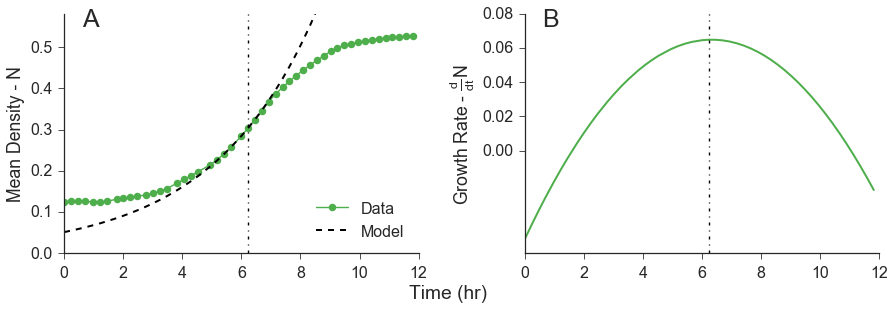

In [148]:
from scipy.misc import derivative
from curveball.utils import smooth

ds = datasets['2015-11-18']
df = ds['dfG']
df = df.groupby('Time').OD.mean().reset_index()
G = df['OD']
tG = df['Time']
G_smooth = smooth(tG, G)
dGdt = derivative(G_smooth, tG)
imax = dGdt.argmax()
tmax = tG[imax]
slopeG, interceptG = curveball.models.fit_exponential_growth_phase(tG, G)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(width * 2, height))

ax[0].plot(tG, G, 'o-', color=green, label='Data')
ax[1].plot(tG, dGdt, color=green, lw=2)
ax[0].plot(tG, np.exp(interceptG + tG * slopeG), color='k', ls=pred_ls, lw=2, label='Model')
ax[0].axvline(tmax, color='k', ls='-.')
ax[1].axvline(tmax, color='k', ls='-.')

ax[0].set_ylabel(r'Mean Density - N')
ax[0].set_ylim(0, 1.1*G.max())
ax[0].legend(loc='lower right')
# ax[0].text(8.5, 0.1, r'$N(t) = N_0e^{rt}$'+'\n $N_0$ = {:.2g}\n $r$ = {:.2g}'.format(np.exp(interceptG), slopeG), fontsize=16)

ax[1].set_ylabel(r'Growth Rate - $\frac{d}{dt}N$')
ax[1].set_yticks([0, 0.02, 0.04, 0.06, 0.08])

fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCDEFGH'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)
fig.tight_layout()
sns.despine()
fig.savefig('Fig-exponential_model-explained.png')
fig.savefig('Fig-exponential_model-explained.pdf', dpi=300)

In [104]:
def expnential_model(mGreen, mRed, frac_green=0.3, frac_red=0.3, di=2, 
                     colors=sns.color_palette('Set1', 3)[::2], ax=None, PLOT=False):
    G = np.unique(mGreen.best_fit)
    tG = np.unique(mGreen.userkws['t'])
    
    R = np.unique(mRed.best_fit)
    tR = np.unique(mRed.userkws['t'])
    
    slopeG, interceptG = curveball.models.fit_exponential_growth_phase(tG, G)
    slopeR, interceptR = curveball.models.fit_exponential_growth_phase(tR, R)    

    if PLOT:
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        ax.plot(tG, G, color=colors[1])
        ax.plot(tG, np.exp(slopeG * tG + interceptG), '--', color=colors[1])
        ax.plot(tR, R, color=colors[0])
        ax.plot(tR, np.exp(slopeR * tR + interceptR), '--', color=colors[0])

        ax.set(ylim=(0.9*min(G.min(), R.min()), 1.1*max(G.max(), R.max())), xlabel='Time (hour)', ylabel='log OD', yscale='log')        
        fig.tight_layout()
        sns.despine()
        return slopeG, interceptG, slopeR, interceptR, fig, ax 
    return slopeG, interceptG, slopeR, interceptR

2015-11-18 r_G=0.268, r_R=0.302
2015-12-14 r_G=0.229, r_R=0.299
2016-01-06 r_G=0.2, r_R=0.305


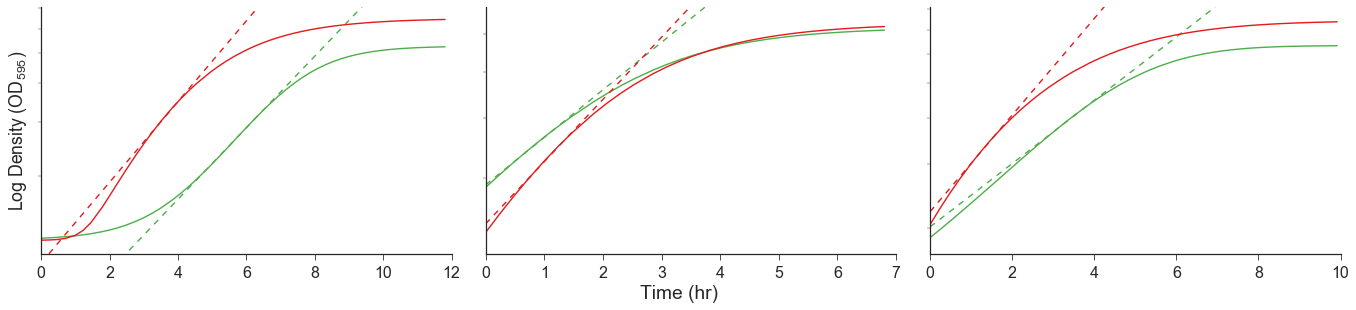

In [15]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=False, figsize=(width * cols, height))
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i,(name, ds) in enumerate(datasets.items()):
    ds['slopeG'], ds['interceptG'], ds['slopeR'], ds['interceptR'], _, _  = expnential_model(ds['model_G'], ds['model_R'], ax=ax[i], PLOT=True)    
    print(name, 'r_G={:.3g}, r_R={:.3g}'.format(ds['slopeG'], ds['slopeR']))
    ax[i].set(title='', xlabel='', yticks=[])
    if i == 0:
        ax[i].set(ylabel=r'Log Density ($OD_{595}$)')
    else:
        ax[i].set(ylabel='')
fig_xlabel(fig, 'Time (hr)')
fig.tight_layout()
sns.despine()
fig.savefig('Fig-exponential_model.png')
fig.savefig('Fig-exponential_model.pdf', dpi=300)

## Competition experiment

In [16]:
for ds in datasets.values():
    ds['flow_summary_df'] = pd.read_csv(ds['flow_summary_file'])

In [17]:
ode = curveball.competitions.baranyi_roberts_yr2

for name, ds in datasets.items():
    print(name, end=" ")
    K = ds['model_G'].best_values['K'], ds['model_R'].best_values['K']
    r = ds['model_G'].best_values['r'], ds['model_R'].best_values['r']
    nu = ds['model_G'].best_values.get('nu',1), ds['model_R'].best_values.get('nu',1)
    q0 = ds['model_G'].best_values.get('q0', np.inf), ds['model_R'].best_values.get('q0', np.inf)
    v = ds['model_G'].best_values.get('v', r[0]), ds['model_R'].best_values.get('v', r[1])
    y0 = ds['model_G'].best_values['y0']/2, ds['model_R'].best_values['y0']/2

    f0 = np.array(ds['flow_summary_df'][ds['flow_summary_df'].time==ds['flow_summary_df'].time.min()].freq_mean) # initial frequencies from flow data
    RG_model_min = np.unique(ds['model_RG'].best_fit).min() # expected initial mixed culture OD from mixed culture model
    RG_mean = ds['dfRG'].groupby('Time').OD.mean().as_matrix()
    RG_std = ds['dfRG'].groupby('Time').OD.std().as_matrix()
    RG_t = np.unique(ds['dfRG'].Time)
    G0, R0 = f0 * RG_model_min # expected initial OD of each strain in mixed culture

    t, y, a = curveball.competitions.fit_and_compete(
        ds['model_G'], 
        ds['model_R'], 
        ds['dfRG'],
        ode=ode,
        y0=(G0, R0),
        aguess=(1,1),
        PLOT=False,
        fixed=False
    )
    MRSE = ((odeint(ode, (G0, R0), RG_t, args=(K, r, nu, q0, v, a)).sum(axis=1) - RG_mean)**2).mean()
    
    t_fixed, y_fixed, _ = curveball.competitions.fit_and_compete(
        ds['model_G'], 
        ds['model_R'], 
        ds['dfRG'],
        ode=ode,
        y0=(G0, R0),
        aguess=(1,1),
        PLOT=False,
        fixed=True
    )
    
    ds['a'] = a
    ds['RG_model_min'] = RG_model_min
    ds['RG_mean'] = RG_mean
    ds['RG_std'] = RG_std
    ds['RG_t'] = RG_t
    ds['predicted_t'] = t
    ds['predicted_y'] = y
    ds['predicted_t_fixed'] = t_fixed
    ds['predicted_y_fixed'] = y_fixed
    ds['MRSE'] = MRSE
 
    # exponential model
    slopeG = ds['slopeG']
    slopeR = ds['slopeR']
    Nexp = G0*np.exp(slopeG * t), R0*np.exp(slopeR * t)
    ds['Gexp'] = Nexp[0] 
    ds['Rexp'] = Nexp[1] 
    ds['Bexp'] = Nexp[0] + Nexp[1]
    ds['pGexp'] = Nexp[0]/ds['Bexp']
    ds['pRexp'] = Nexp[1]/ds['Bexp']

2015-11-18 2015-12-14 2016-01-06 

2015-11-18 MRSE: 0.00013 a1=10, a2=0.77
2015-12-14 MRSE: 0.0001 a1=3.7, a2=2
2016-01-06 MRSE: 6.5e-05 a1=0.11, a2=0.53


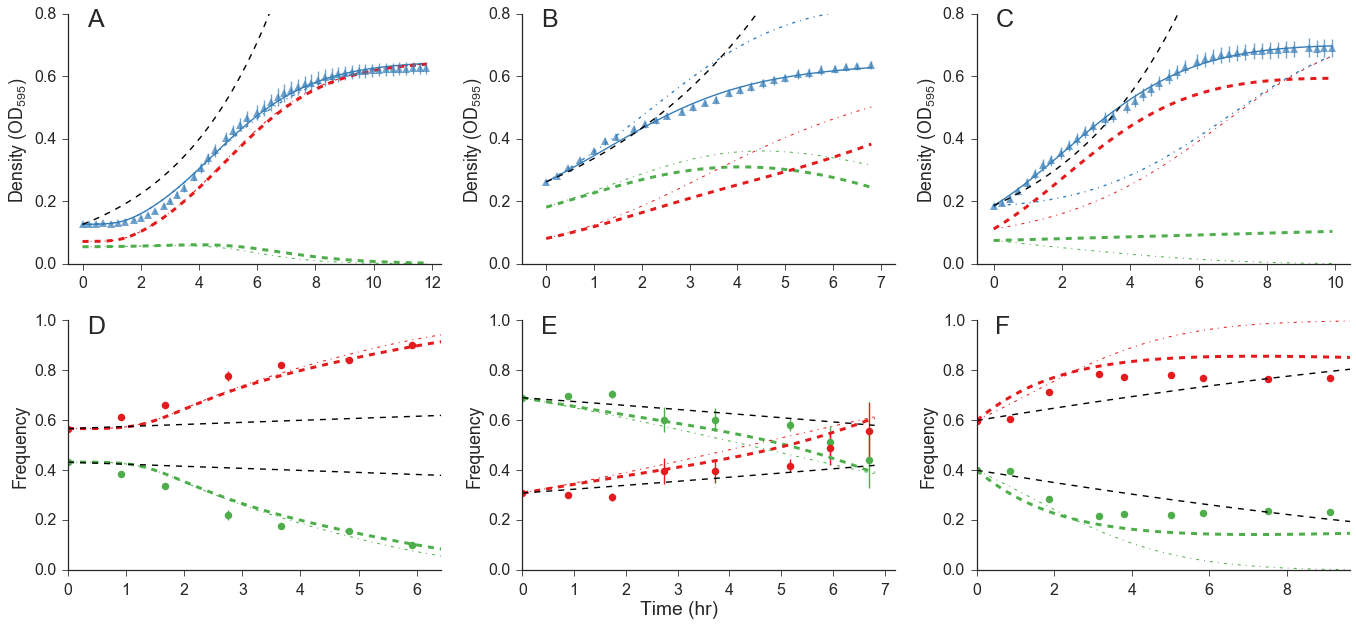

In [20]:
rows = 2
cols = len(datasets)

fig, ax = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(width * cols, height * rows))
ax.resize((rows, cols))
for col,(name, ds) in enumerate(datasets.items()):
    if col >= cols:
        break
   
    RG_mean = ds['RG_mean']
    RG_std = ds['RG_std']
    RG_t = ds['RG_t']
    t = ds['predicted_t']
    y = ds['predicted_y']
    MRSE = ds['MRSE']
    t_fixed = ds['predicted_t_fixed']
    y_fixed = ds['predicted_y_fixed']    
    flow_df = ds['flow_summary_df']
    
    ysum = y.sum(axis=1)
    ysum_fixed = y_fixed.sum(axis=1)
    p1 = y[:, 0] / ysum
    p2 = y[:, 1] / ysum
    p1_fixed = y_fixed[:, 0] / ysum_fixed
    p2_fixed = y_fixed[:, 1] / ysum_fixed
    
    ### TOP PANELS
    # comp model fit
    ax[0, col].plot(t, ysum, color=blue, ls=fit_ls)
    # predictions based on comp model fit
    ax[0, col].plot(t, y[:, 0], color=green, ls=pred_ls, lw=3)
    ax[0, col].plot(t, y[:, 1], color=red, ls=pred_ls, lw=3)
    # predictions based on growth model fit
    ax[0, col].plot(t_fixed, y_fixed[:, 0], color=green, ls=fixed_pred_ls, lw=1)
    ax[0, col].plot(t_fixed, y_fixed[:, 1], color=red, ls=fixed_pred_ls, lw=1)
    ax[0, col].plot(t_fixed, ysum_fixed, color=blue, ls=fixed_pred_ls)
    # OD data
    ax[0, col].errorbar(RG_t, RG_mean, RG_std, fmt='^', color=blue, alpha=0.7)
    # exponential model
#     ax[0, col].plot(t, ds['Gexp'], color=green, ls=pred_ls) # exponential model        
#     ax[0, col].plot(t, ds['Rexp'], color=red, ls=pred_ls) # exponential model        
    ax[0, col].plot(t, ds['Bexp'], color='k', ls=pred_ls) # exponential model        

    # flow data
#     flow_time0 = flow_df[flow_df.time==flow_df.time.min()]
#     factor = RG_mean.min() / flow_time0.real_count_mean.sum()
    
#     idx = flow_df.Strain == 'Green'    
#     ax[0, col].errorbar(
#         flow_df[idx].time, 
#         flow_df[idx].real_count_mean.as_matrix() * factor, 
#         flow_df[idx].real_count_std.as_matrix() * factor, 
#         marker='o', 
#         ls='', 
#         color=green
#     )
#     idx = flow_df.Strain == 'Red'    
#     ax[0, col].errorbar(
#         flow_df[idx].time, 
#         flow_df[idx].real_count_mean.as_matrix() * factor, 
#         flow_df[idx].real_count_std.as_matrix() * factor, 
#         marker='o', 
#         ls='', 
#         color=red
#     )
    
    ### BOTTOM PANELS
    ax[0, col].set(
        ylabel=r'Density ($OD_{595}$)', 
        xlim=(-0.5, t.max() + 0.5),
        title="",
    )
    if 'ylim' in ds:
        ax[0, col].set_ylim(ds['ylim'])
        dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
        ax[0, col].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))

    ###
    # prediction based on comp model fit
    ax[1, col].plot(t, p1, color=green, ls=pred_ls, lw=3)
    ax[1, col].plot(t, p2, color=red, ls=pred_ls, lw=3)
    # prediction based on growth model fit
    ax[1, col].plot(t_fixed, p1_fixed, color=green, ls=fixed_pred_ls, lw=1)
    ax[1, col].plot(t_fixed, p2_fixed, color=red, ls=fixed_pred_ls, lw=1)
    # flow data
    idx = ds['flow_summary_df'].Strain == 'Green'
    ax[1, col].errorbar(
        ds['flow_summary_df'][idx].time, 
        ds['flow_summary_df'][idx].freq_mean.as_matrix(), 
        ds['flow_summary_df'][idx].freq_std.as_matrix(), 
        marker='o', 
        ls='', 
        color=green
    )
    idx = ds['flow_summary_df'].Strain == 'Red'
    ax[1, col].errorbar(
        ds['flow_summary_df'][idx].time, 
        ds['flow_summary_df'][idx].freq_mean.as_matrix(), 
        ds['flow_summary_df'][idx].freq_std.as_matrix(), 
        marker='o',
        ls='', 
        color=red
    )
    # exponential model
    ax[1, col].plot(t, ds['pGexp'], color='k', ls=pred_ls) # exponential model
    ax[1, col].plot(t, ds['pRexp'], color='k', ls=pred_ls) # exponential model
    ###
    
    ax[1, col].set(
        ylabel='Frequency',        
        xlim=(0, ds['flow_summary_df'][idx].time.max() + 0.5),
        ylim=(0, 1),
        title="",
        yticks=np.linspace(0, 1.0, 6),
        
    )
    
    print(name, "MRSE: {:.2g}".format(MRSE), "a1={:.2g}, a2={:.2g}".format(*ds['a'])) 

fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCDEFGH'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)
    
sns.despine()
fig.tight_layout()
fig.savefig('Fig-Competition_prediction.png')
fig.savefig('Fig-Competition_prediction.pdf', dpi=300)

2015-11-18 0.0107551549184
2015-12-14 0.0101219840009
2016-01-06 0.0235493797687


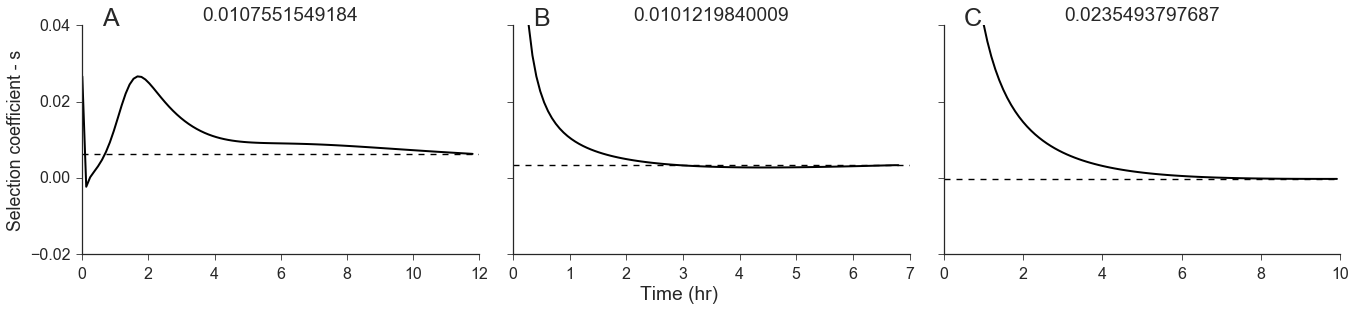

In [214]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=True, figsize=(width * cols, height))
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i,(name, ds) in enumerate(datasets.items()):
    t = ds['predicted_t']
    y = ds['predicted_y']
    s, _, _ = curveball.competitions.selection_coefs_ts(t, y[:,::-1], ax=ax[i], PLOT=True)
    print(name, s.mean())
    
    ax[i].get_lines()[0].set_color('k')
    ax[i].get_lines()[0].set_linewidth(2)
    ax[i].axhline(s[-1], color='k', ls='--')
    ax[i].set(xlabel='', ylim=(-0.02, 0.04), yticks=[-0.02, 0, 0.02, 0.04], title=s.mean())
    if i == 0:
        ax[i].set(ylabel=r'Selection coefficient - s')
    else:
        ax[i].set(ylabel='')
        
fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCD'[i], (0.05, 1.0), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
sns.despine()
# fig.savefig('Fig-selection-coefficient.png')
# fig.savefig('Fig-selection-coefficient.pdf', dpi=300)

# Colophon

This notebook was written by [Yoav Ram](http://www.yoavram.com) ([yoav@yoavram.com](mailto:yoav@yoavram.com)) and is part of the supporting material for a manuscript.

The notebook was written using Python 3.4.4, IPython 4.1.2, Jupyter 4.0.6, NumPy 1.10, SciPy 0.17, Pandas 0.18, Matplotlib 1.5.1, lmfit 0.9.2, Seaborn 0.7, Scikit-learn 0.17.1, but should work with Python 3.5 and Python 2.7 and earlier versions of most of the packages (lmfit should be at least 0.9.0).

This work is licensed under a CC BY-SA 4.0 International License. Attribution should be given by citing the original manuscript.